# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Необходимо построить модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделать выводы.


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Импортируем необходимые библиотеки.

In [1]:
import re
import nltk
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
from sklearn.exceptions import ConvergenceWarning

# Устанавливаем параметр для tqdm
tqdm.pandas()

# Игнорируем предупреждения ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

Загрузим необходимые ресурсы для работы с токенизацией и лемматизацией текста на английском языке

In [2]:
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

True

In [3]:
try:
    df = pd.read_csv('toxic_comments.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
def analysis(df):
    print('Вывод первых 5 строк данных')
    print()
    display(df.head())
    print()
    print('Информация о датафрейме')
    print()
    display(df.info())
    print()
    print('Подсчет пропусков')
    print()
    print(df.isnull().sum())
    print()
    print('Подсчет дубликатов')
    print(df.duplicated().sum())

In [5]:
analysis(df)

Вывод первых 5 строк данных



,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0



Информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None


Подсчет пропусков

Unnamed: 0    0
text          0
toxic         0
dtype: int64

Подсчет дубликатов
0


Мы загрузили данные. В таблице 3 столбца и 159292 строк. Типы данных в столбцах — int64(2), object(1).
- Столбец text содержит текст комментария
- Столбец toxic — целевой признак.

Пропусков и явных дубликатов нет. 
В данных англоязычный текст.

Удалим столбец 'Unnamed: 0' - он не несет никакой информации, только повторяет индексацию.

In [6]:
df = df.drop('Unnamed: 0', axis=1)
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Посмотрим на распределение классов в toxic -  целевой переменной

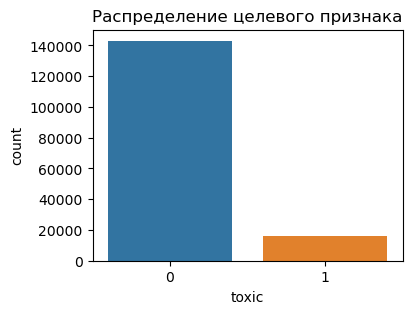

In [7]:
plt.figure(figsize=(4, 3))
sns.countplot(x='toxic', data=df)
plt.title('Распределение целевого признака')
plt.show();

Токсичных комментариев намного меньше, чем обычных. Имеем дисбаланс классов. Это будем учитывать при делении на выборки.

**Регулярные выражения**

От лишних символов текст очистят регулярные выражения.
Это инструмент определяет из каких частей состоит строка и какие в них символы. 
Напишем функцию, которая принимает текст в качестве аргумента и использует регулярное выражение [^a-zA-Z ] для удаления всех символов, кроме букв и пробелов, а затем удаляет лишние пробелы с помощью ' '.join и возвращает очищенный текст.

In [8]:
def clear_text(text):
    text = re.sub(r'[^a-zA-Z\' ]', ' ', text.lower()) 
    join_list = " ".join(text.split())
    return join_list

In [9]:
df['lemm_text'] = df['text'].apply(clear_text)
df.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,d'aww he matches this background colour i'm se...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i'm really not trying to edit war it's...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can't make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...


Удалим из текста стоп-слова 

In [10]:
stopword = stopwords.words('english')
# функция для очистки от стоп-слов
def delete_stopwords(lemm_text):
    tokens = lemm_text.split()
    filtered_text = [word for word in tokens if word.lower() not in stopword]
    return ' '.join(filtered_text)

In [11]:
df['lemm_text'] = df['lemm_text'].apply(delete_stopwords)
df.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,d'aww matches background colour i'm seemingly ...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i'm really trying edit war guy constan...
3,"""\nMore\nI can't make any real suggestions on ...",0,can't make real suggestions improvement wonder...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page that's


**Лемматизация**

Прежде чем извлечь признаки из текста, упростим его. 

Рассмотрим этапы предобработки текста:
- Токенизация (англ. tokenization) — разбиение текста на токены: отдельные фразы, слова, символы.
- Лемматизация (англ. lemmatization) — приведение слова к начальной форме — лемме.

In [12]:
def lemmatize(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [13]:
lemmatizer = WordNetLemmatizer()
# проверим результат лемматизации на одном предложеним
sentence = 'The striped bats are hanging on their feet for best'
print([lemmatizer.lemmatize(w, lemmatize(w)) for w in nltk.word_tokenize(sentence)])

['The', 'strip', 'bat', 'be', 'hang', 'on', 'their', 'foot', 'for', 'best']


In [14]:
lemmatizer = WordNetLemmatizer()

df['lemm_text'] = df['lemm_text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(w, lemmatize(w)) 
                                                            for w in nltk.word_tokenize(x)]))

In [15]:
df['lemm_text']

0         explanation edits make username hardcore metal...
1         d'aww match background colour i 'm seemingly s...
2         hey man i 'm really try edit war guy constantl...
3         ca n't make real suggestion improvement wonder...
4                     sir hero chance remember page that 's
                                ...                        
159287    second time ask view completely contradicts co...
159288                 ashamed horrible thing put talk page
159289    spitzer umm there actual article prostitution ...
159290    look like actually put speedy first version de...
159291    really think understand come idea bad right aw...
Name: lemm_text, Length: 159292, dtype: object

In [16]:
df = df.drop(['text'], axis=1)
df.head()

,toxic,lemm_text
0,0,explanation edits make username hardcore metal...
1,0,d'aww match background colour i 'm seemingly s...
2,0,hey man i 'm really try edit war guy constantl...
3,0,ca n't make real suggestion improvement wonder...
4,0,sir hero chance remember page that 's


**Выводы:**

- Посмотрели на распределение классов в toxic -  обнаружили дисбаланс классов в целевой переменной. При обучении моделей будем этот факт учитывать.
- Очистили датасет от лишних символов.
- Удалили из текста стоп-слова.
- Провели токенизацию — разбиение текста на токены: отдельные фразы, слова, символы и лемматизацию — приведение слова к начальной форме — лемме.
- Создали столбец с лемматизированным текстом.

## Обучение

Так как мы имеем большой объем данных, возьмем из выборки только 70 000 объектов для исследования, чтобы модели не грузились по несколько часов в ожидании резутатов. 

In [17]:
df_copy = df.sample(n = 70000, random_state=12345)
df_copy.shape

(70000, 2)

**Разобьём данные на тренировочную и тестовую выборки**

In [18]:
target = df_copy['toxic']
features = df_copy.drop(['toxic'], axis=1)
# при делении на выборки применим стратификацию, чтобы сохранить баланс классов
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, random_state=12345, stratify=target) 
print(features_train.shape)
print(features_test.shape)

(63000, 1)
(7000, 1)


Чтобы алгоритмы умели определять тематику и тональность текста, их нужно обучить на корпусе (англ. corpus). Это набор текстов, в котором эмоции и ключевые слова уже размечены.

In [19]:
corpus_train = features_train['lemm_text']
corpus_test = features_test['lemm_text']

Вычислим TF-IDF для обучающей и тестовой выборки

In [20]:
# объявление TFIDF-векторизатора
count_tf = TfidfVectorizer() # создаем счетчик

In [21]:
train_tf = count_tf.fit_transform(corpus_train) # обучаем и трансформируем
test_tf = count_tf.transform(corpus_test) # трансформируем тестовую без обучения
train_tf.shape
test_tf.shape

(7000, 86928)

**DecisionTreeClassifier**

In [22]:
model = DecisionTreeClassifier(random_state=12345, class_weight='balanced')

params = {'criterion': ['gini', 'entropy'], 'max_depth': [10, 31, 2]}

search_dt = GridSearchCV(model, params, scoring='f1', cv=5)
search_dt.fit(train_tf, target_train)
print('F1', round(search_dt.best_score_, 2))

F1 0.64


**RandomForestClassifier**

In [23]:
model_rf = RandomForestClassifier(random_state=12345, class_weight='balanced')

params = {'max_depth': [1,13, 2],'n_estimators': [10, 51, 5]}

search_rf = GridSearchCV(model_rf, params, scoring='f1', cv=5)
search_rf.fit(train_tf, target_train)
print('F1', round(search_rf.best_score_, 2))

F1 0.37


**LogisticRegression**

In [24]:
model_lr = LogisticRegression(random_state=12345, class_weight='balanced')

params= [{'solver': ['newton-cg', 'lbfgs', 'liblinear']},
              {'C':[0.1, 1, 10, 100]}]
search_lr = GridSearchCV(model_lr, params, cv=5, verbose=1, scoring='f1')
search_lr.fit(train_tf, target_train)
best_lr = search_lr.best_estimator_
print('F1', round(search_lr.best_score_, 2))

Fitting 5 folds for each of 7 candidates, totalling 35 fits
F1 0.76


**Вывод:**

Разделили датафрейм на обучающую и тестовую выборки. К текстам была применена векторизация TF-IDF.

Обучили следующие модели: LogisticRegression, RandomForestClassifier, DecisionTreeClassifier.

Модель LogisticRegression показала наилучший результат значения метрики F1 0.76 на тренировочных данных.

**Тестирование**

Модель LogisticRegression показала наилучший результат значения F1 на тренировочных данных. Проверим как покажет себя модель на тестовой выборке.

In [25]:
pred_test_lr = best_lr.predict(test_tf)
rmse_lr = f1_score(target_test, pred_test_lr) 

print('RMSE на тестовых данных:', round(rmse_lr, 2))

RMSE на тестовых данных: 0.76


## Выводы


Таким образом, мы изучили данные интернет-магазина «Викишоп», который запускает новый сервис, где пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. 

В проекте была проделана следующая работа:

- Провели первичный анализ данных. Пропусков и явных дубликатов не обнаружено. В данных англоязычный текст.
- Посмотрели на распределение классов в toxic -  обнаружили дисбаланс классов в целевой переменной. При обучении моделей этот факт учли.
- Очистили датасет от лишних символов.
- Удалили из текста стоп-слова.
- Провели токенизацию — разбиение текста на токены: отдельные фразы, слова, символы и лемматизацию — приведение слова к начальной форме — лемме.
- Создали столбец с лемматизированным текстом.
- Разбили данные на тренировочную и тестовую выборки.
- К текстам была применена векторизация TF-IDF.
- Обучили следующие модели: LogisticRegression, RandomForestClassifier, DecisionTreeClassifier.
- Модель LogisticRegression показала наилучший результат значения метрики F1 0.76 на тренировочных данных.
- На тестовых данных модель LogisticRegression показала результат значения метрики F1 0.76.

Таким образом, требование заказчиков выполнено.